In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import pytry

In [2]:
data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)

#data = pd.read_csv("two_datasets.csv", low_memory=False) #labs 444

x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,218]).astype(str) #array of labels (purple child annotations, engagement)
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

dt = 0.001

In [3]:
def extract_pattern(start, end): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/dt))*dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return t, result

In [4]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

In [5]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

for i in range(1,(len(start)-1)):
    if label[i]==('noplay'):
        ti, pi = extract_pattern(start[i], end[i])
        t_noplay.append(ti)
        p_noplay.append(pi)
    if label[i]==('goaloriented'):
        ti, pi = extract_pattern(start[i], end[i])
        t_goal.append(ti)
        p_goal.append(pi)
    if label[i]==('aimless'):
        ti, pi = extract_pattern(start[i], end[i])
        t_aim.append(ti)
        p_aim.append(pi)

In [6]:
############ randomly split data 80/20 into training and testing sets ############ 
random.shuffle(p_goal)
goal_train = p_goal[:(int(len(p_goal)*0.8))] 
goal_test = p_goal[(int(len(p_goal)*0.8)):]

random.shuffle(p_noplay)
noplay_train = p_noplay[:(int(len(p_noplay)*0.8))]
noplay_test = p_noplay[(int(len(p_noplay)*0.8)):]

[array([[ 0.564    ,  0.5977   ,  0.5828   , ..., -0.334    ,  0.884    ,
        -0.328    ],
       [ 0.564033 ,  0.597697 ,  0.582878 , ..., -0.33412  ,  0.88388  ,
        -0.32818  ],
       [ 0.564066 ,  0.597694 ,  0.582956 , ..., -0.33424  ,  0.88376  ,
        -0.32836  ],
       ...,
       [ 0.528445 ,  0.598675 ,  0.54699  , ..., -0.0603   ,  0.8948   ,
        -0.44305  ],
       [ 0.5284615,  0.5987125,  0.546963 , ..., -0.05991  ,  0.89516  ,
        -0.442435 ],
       [ 0.528478 ,  0.59875  ,  0.546936 , ..., -0.05952  ,  0.89552  ,
        -0.44182  ]]), array([[ 0.5297  ,  0.5878  ,  0.5479  , ..., -0.231   ,  0.913   ,
        -0.336   ],
       [ 0.529856,  0.58777 ,  0.54802 , ..., -0.23112 ,  0.91306 ,
        -0.33579 ],
       [ 0.530012,  0.58774 ,  0.54814 , ..., -0.23124 ,  0.91312 ,
        -0.33558 ],
       ...,
       [ 0.515724,  0.597127,  0.536698, ..., -0.26345 ,  0.87773 ,
        -0.40027 ],
       [ 0.515616,  0.597118,  0.536632, ..., -0.2633  , 

In [7]:
############ create pca model and convert each pattern into single dimension (first PCA construct) ############ 
train_all = np.vstack(goal_train+noplay_train)
pca_model = PCA(n_components=2).fit(train_all)

goal_patterns1 = {}
goal_patterns2 = {}
i=0
for gp in goal_train:
    goal_patterns1[i] = pca_model.transform(gp)[:,0]
    goal_patterns2[i] = pca_model.transform(gp)[:,1]
    i+=1

noplay_patterns1 = {}
noplay_patterns2 = {}
i=0
for npp in noplay_train:
    noplay_patterns1[i] = pca_model.transform(npp)[:,0]
    noplay_patterns2[i] = pca_model.transform(npp)[:,1]
    i+=1

In [8]:
goal_patterns1 = [(goal_patterns1[key]) for key in goal_patterns1.keys()]
goal_patterns2 = [(goal_patterns2[key]) for key in goal_patterns2.keys()]
noplay_patterns1 = [(noplay_patterns1[key]) for key in noplay_patterns1.keys()]
noplay_patterns2 = [(noplay_patterns2[key]) for key in noplay_patterns2.keys()]

goal_patterns = np.vstack([goal_patterns1[0], goal_patterns2[0]]).T
for gp in range(1,len(goal_train)):
    goal_patterns = np.append(goal_patterns, (np.vstack([goal_patterns1[gp], goal_patterns2[gp]]).T), axis=0) 
noplay_patterns = np.vstack([noplay_patterns1[0], noplay_patterns2[0]]).T
for npp in range(1,len(noplay_train)):
    noplay_patterns = np.append(noplay_patterns, (np.vstack([noplay_patterns1[npp], noplay_patterns2[npp]]).T), axis=0) 

In [9]:
############ TRAINING WITH 80% ############ 
D = 2

theta = 0.5
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    #rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=q.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.LIFRate()))

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [10]:
s_window = int(theta/dt)
s_pattern = len(min(goal_patterns1, key=len))

t_window = np.linspace(0, 1, s_window)
inv_basis = rw[0].inverse_basis(t_window)

n_keep = 10*1000

eval_points=[]
target = []
for i in range(s_pattern)[:n_keep]:
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns, i)[:s_window]).T)
    target.append([1])
for i in range(s_pattern)[:n_keep]:  
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns, i)[:s_window]).T)
    target.append([-1])
eval_points = np.array(eval_points).reshape(len(eval_points), -1)

In [11]:
############ TEST ON TRAINING PATTERNS ############ 

with net:

    pool = nengo.Ensemble(n_neurons=3000, dimensions=eval_points.shape[1],
                          neuron_type=nengo.LIFRate(), seed=1)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out

    result = nengo.Node(None, size_in=1)
    dec_conn = nengo.Connection(pool, result,
                     eval_points=eval_points, scale_eval_points=False,
                     function=target, synapse=0.1)

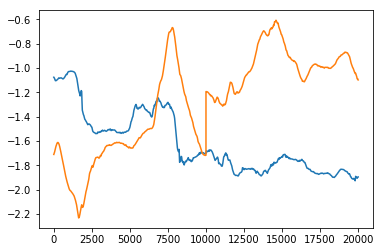

In [13]:
train_all1 = np.array(goal_patterns1[0])
for gp in range(1,(len(goal_patterns1))):
    train_all1 = np.hstack([train_all1,goal_patterns1[gp]])
train_all1 = train_all1[:n_keep]
for npp in range(0,(len(noplay_patterns1))):
    train_all1 = np.hstack([train_all1,noplay_patterns1[npp]])
train_all1 = train_all1[:n_keep*2]

train_all2 = np.array(goal_patterns2[0])
for gp in range(1,(len(goal_patterns2))):
    train_all2 = np.hstack([train_all2,goal_patterns2[gp]])
train_all2 = train_all2[:n_keep]
for npp in range(0,(len(noplay_patterns2))):
    train_all2 = np.hstack([train_all2,noplay_patterns2[npp]])
train_all2 = train_all2[:n_keep*2]


train_all = np.vstack([train_all1, train_all2]).T
plt.plot(train_all)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

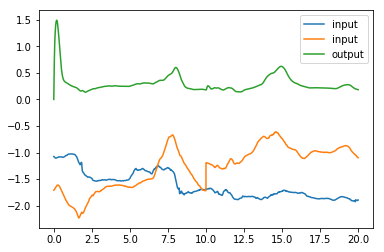

In [14]:
presentation_time_train=0.001

model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(train_all, presentation_time=presentation_time_train))
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
    p_pool = nengo.Probe(pool)
sim = nengo.Simulator(model)
sim.run(20)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

In [15]:
############ GET RESULTS ############ 

goal_mean = np.mean(sim.data[p_result][:n_keep])
noplay_mean = np.mean(sim.data[p_result][n_keep:])

print(goal_mean)
print(noplay_mean)

0.320974738460666
0.274342857758478
